In [127]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers

In [194]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

In [120]:
sys.getsizeof(np.zeros((3,128,64,88), dtype=np.int64))/1024

16896.140625

In [121]:
# with open('H2', 'wb') as f:
#     pickle.dump(mode_datas, f)
for md in model_datas:
    with open('training_data/' + md.name + 'v0', 'wb') as f:
        pickle.dump(md.data, f)
    
model_datas[0].name

'H'

In [183]:
print(model_datas['R'].data[57])

  (44, 15)	1.0
  (48, 15)	1.0
  (0, 22)	1.0
  (4, 22)	1.0
  (8, 22)	1.0
  (12, 22)	1.0
  (16, 22)	1.0
  (20, 22)	1.0
  (24, 22)	1.0
  (28, 22)	1.0
  (32, 22)	1.0
  (36, 22)	1.0
  (40, 22)	1.0
  (44, 22)	1.0
  (48, 22)	1.0
  (64, 22)	1.0
  (68, 22)	1.0
  (69, 22)	1.0
  (70, 22)	1.0
  (71, 22)	1.0
  (72, 22)	1.0
  (74, 22)	1.0
  (76, 22)	1.0
  (80, 22)	1.0
  (84, 22)	1.0
  :	:
  (116, 51)	1.0
  (117, 51)	1.0
  (118, 51)	1.0
  (119, 51)	1.0
  (120, 51)	1.0
  (124, 51)	1.0
  (108, 53)	1.0
  (110, 53)	1.0
  (118, 53)	1.0
  (119, 53)	1.0
  (120, 53)	1.0
  (124, 53)	1.0
  (112, 55)	1.0
  (116, 55)	1.0
  (117, 55)	1.0
  (118, 55)	1.0
  (119, 55)	1.0
  (120, 55)	1.0
  (124, 55)	1.0
  (116, 56)	1.0
  (117, 56)	1.0
  (118, 56)	1.0
  (119, 56)	1.0
  (120, 56)	1.0
  (124, 56)	1.0


In [195]:
pm =data.examples2pm(model_datas)
pm.write('test.mid')


example 14 chosen
(129, 88)


In [188]:
model_datas = data.folder2examples('training_data\midi_files', sparse=True, use_base_key=False, beats_per_ex=32)
# with open('H2', 'wb') as f:
#     pickle.dump(mode_datas, f)

processing file 0 of 19
processing file 10 of 19
(128, 88)
(128, 88)
(128, 88)
(128, 88)
(12,)
(1,)


In [105]:
n_notes=88
model_input = namedtuple('input', 'name dim seq')
model_output = namedtuple('output', 'name dim activation')

# model inputs
model_inputs = []
model_inputs.append(model_input('H', n_notes, True))
model_inputs.append(model_input('tempo', 1, False))
model_inputs.append(model_input('key', 12, False))

# model outputs
model_outputs = []
model_outputs.append(model_output('H', n_notes, 'sigmoid'))
# model_outputs.append(model_output('O', n_notes, 'tanh'))
model_outputs.append(model_output('V', n_notes, 'sigmoid'))

# set up keras inputs
seq_length = 64
seq_inputs = [tf.keras.Input(shape=(seq_length,seq_in.dim), name=seq_in.name + '_in') for seq_in in model_inputs if seq_in.seq == True]
aux_inputs = [tf.keras.Input(shape=(aux_in.dim,), name=aux_in.name + '_in') for aux_in in model_inputs if aux_in.seq == False]

for i, model_input in enumerate(model_inputs):
    print(f'input {i}: {model_input.name}')
          
for i, model_output in enumerate(model_outputs):
    print(f'input {i}: {model_output.name}')

# dummy_input = tf.keras.Input(shape=1, name=dummy + '_in')
# starting_zeros = tf.keras.Input(shape=88==88*len(model_outputs), name='zeros')

# # another possible way of doing this
# model_inout = namedtuple('inout', 'name dim seq activation in out')
# H_in = model_inout('H', n_notes, True, 'sigmoid', True, True)
# tempo_in = model_inout('tempo', 1, False, None, True, False)
# key_in = model_inout('key', 12, False, None, True, False)

# O_out = model_inout('O', n_notes, True, 'tanh')
# V_out = model_inout('V', n_notes, True, 'sigmoid', False, True)

input 0: H
input 1: tempo
input 2: key
input 0: H
input 1: V


In [46]:
# z = models.create_LSTMencoder(seq_inputs, aux_inputs, seq_length=seq_length, lstm_layers = 2, dense_layers = 2, hidden_state_size = 64, latent_size = 64,
#                     dense_size = 64)
z = models.create_conv_encoder(seq_inputs, aux_inputs)
outputs = models.create_LSTMdecoder(z, model_outputs, seq_length=seq_length, hidden_state_size = 64,
                    dense_size = 64)
model = tf.keras.Model(inputs=seq_inputs + aux_inputs + [dummy_input], outputs=outputs, name=f'autoencoder')
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 64, 88, 1)    0           H_in[0][0]                       
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 8, 4)     388         lambda_7[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 16, 8, 4)     0           conv2d_15[0][0]                  
________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model)

In [44]:
# dg = ml_classes.ModelDataGenerator(model_datas, ['H', 'tempo', 'key'], ['H', 'V'], batch_size = 30, seq_length=seq_length)
dg = ml_classes.ModelDataGenerator([md for md in model_datas.values()], [model_in.name for model_in in model_inputs], [model_out.name for model_out in model_outputs], batch_size = 30, seq_length=seq_length)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model
# key is not working.
history = model.fit_generator(dg, epochs=3, verbose=1)
# model.fit([model_datas2['H'], model_datas['tempo']],[model_datas['H'], model_datas['V']], epochs=3)


Epoch 1/3
10/10 [==============================] - 9s 868ms/step - loss: 4.6948 - H_out_loss: 3.5187 - V_out_loss: 1.1762 - H_out_accuracy: 0.0186 - V_out_accuracy: 0.0049
Epoch 2/3
10/10 [==============================] - 8s 806ms/step - loss: 4.6704 - H_out_loss: 3.4988 - V_out_loss: 1.1716 - H_out_accuracy: 0.0111 - V_out_accuracy: 0.0060
Epoch 3/3
10/10 [==============================] - 8s 810ms/step - loss: 4.5714 - H_out_loss: 3.4191 - V_out_loss: 1.1523 - H_out_accuracy: 0.0099 - V_out_accuracy: 0.0147


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 0)]          0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
repeat_vector_20 (RepeatVector) (None, 10, 0)        0           input_60[0][0]                   
__________________________________________________________________________________________________
hidden_state_maker (Dense)      (None, 5)            30          input_59[0][0]                   
___________________________________________________________________________________________

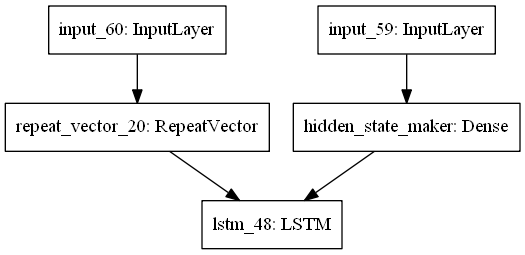

In [94]:
# example of a network with the initial state being set to output of a dense layer
z = tf.keras.Input(shape=[5])
dummy = tf.keras.Input(shape=[0])
h_state = layers.Dense(5, name='hidden_state_maker')(z)
z_repeated = layers.RepeatVector(10)(dummy)
# lstm_cell = layers.LSTM(5)
# x = lstm_cell(z_repeated, initial_state=[h_state, h_state])
x = layers.LSTM(5)(z_repeated, initial_state=[h_state, h_state])

x.shape[1]
test_model = tf.keras.Model(inputs=[z, dummy], outputs=x)
test_model.summary()
tf.keras.utils.plot_model(test_model)

In [96]:
con = layers.concatenate

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           [(None, 0)]          0                                            
__________________________________________________________________________________________________
input_77 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dummy_repeater (RepeatVector)   (None, 8, 0)         0           input_78[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 32)           1056        input_77[0][0]                   
___________________________________________________________________________________________

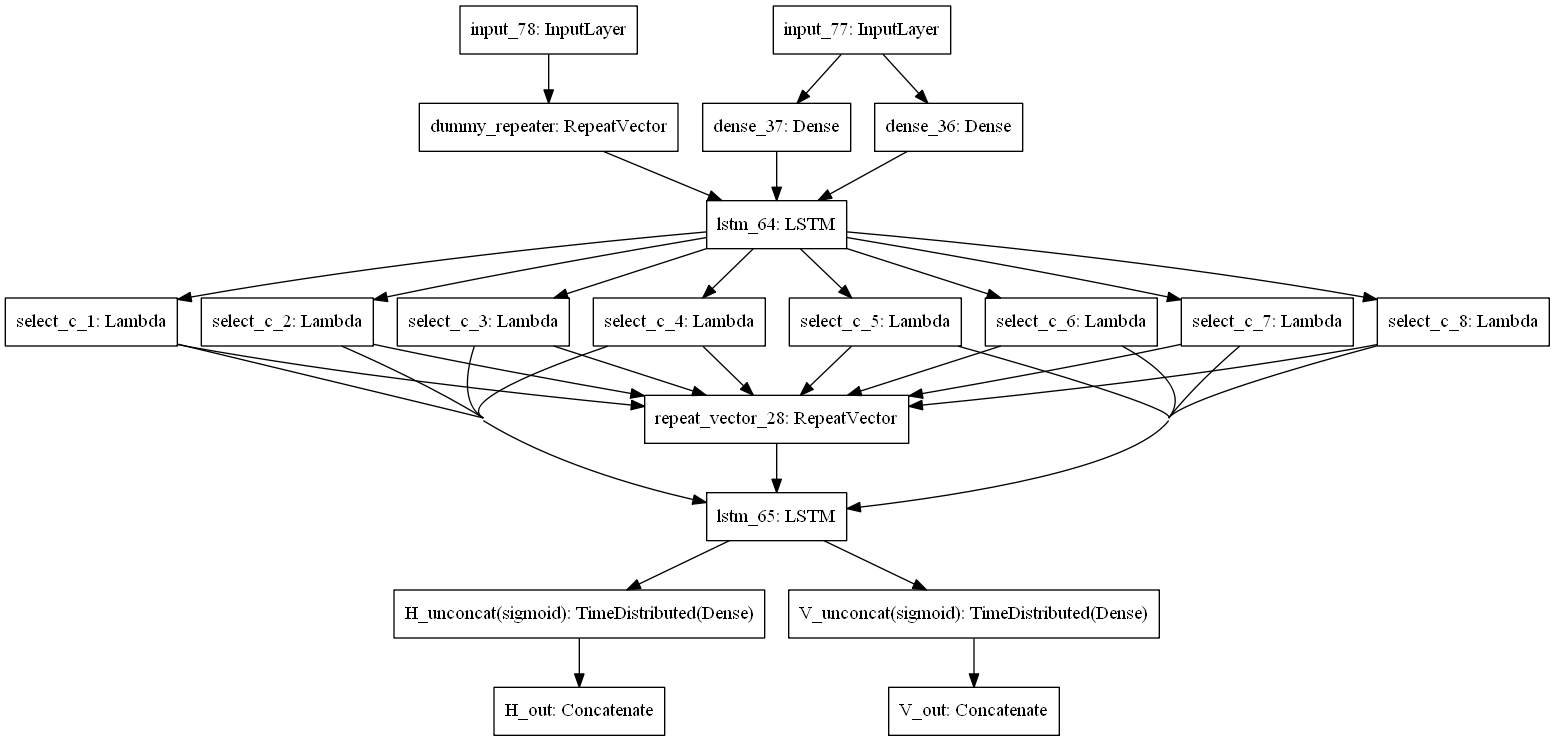

In [114]:
def create_hierarchical_decoder(z, outputs_raw, dummy_in, seq_length=seq_length, dense_size=256, conductor_state_size=32, decoder_state_size=256,
                conductors=2, conductor_steps=8, recurrent_dropout=0.0):
    """create a hierarchical decoder

    Arguments:

    Notes:
    still need to sort out initial states...

    """

    # repeat for however many conductor time steps there are
    conductor_substeps = int(seq_length / conductor_steps)

    # dummy input is just a zero. But it controls number of time steps, by choosing how many times to repeat it.
    #...or perhaps I can nothing as the input? dummy = tf.keras.Input(shape=[0])
    repeat_dummy = layers.RepeatVector(conductor_steps, name='dummy_repeater')(dummy_in)

    # get the conductor initial state by passing z through dense layer
    h0 = layers.Dense(conductor_state_size, activation='tanh')(z)
    c0 = layers.Dense(conductor_state_size, activation='tanh')(z)

    # get the embeddings for lstm hidden states
    all_c = layers.LSTM(conductor_state_size, return_sequences=True, recurrent_dropout=recurrent_dropout)(repeat_dummy, initial_state=[h0, c0])

    c_repeater = layers.RepeatVector(conductor_substeps)
    decoder_lstm = layers.LSTM(conductor_state_size, return_sequences=True, recurrent_dropout=recurrent_dropout)
    output_fns = [layers.TimeDistributed(layers.Dense(output.dim, activation=output.activation, name=output.activation), name=output.name + '_unconcat') for output in outputs_raw]

    outputs = [[] for i in range(len(output_fns))]
    for i in range(all_c.shape[1]):
        c = layers.Lambda(lambda x: x[:,i,:], name=f'select_c_{i + 1}')(all_c)
        c_repeated = c_repeater(c)

        # at this point for training, I need to have targets for previous timesteps appended to c_repeated, for teacher forcing.

        x = decoder_lstm(c_repeated, initial_state=[c,c])
        for i in range(len(output_fns)):
            outputs[i].append(output_fns[i](x))

    final_concat = layers.concatenate
    outputs = [final_concat(unconcat_out, axis=-2, name=raw_out.name + '_out') for unconcat_out, raw_out in zip(outputs, outputs_raw)]
    
    return outputs

# # model outputs
# model_outputs = []
# model_outputs.append(model_output('H', n_notes, 'sigmoid'))
# # model_outputs.append(model_output('O', n_notes, 'tanh'))
# model_outputs.append(model_output('V', n_notes, 'sigmoid'))

z = tf.keras.Input(shape=[32])
dummy = tf.keras.Input(shape=[0])
outputs = create_hierarchical_decoder(z, model_outputs, dummy)
test_decoder = tf.keras.Model(inputs=[z, dummy], outputs=outputs)
test_decoder.summary()
tf.keras.utils.plot_model(test_decoder)